In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [40]:
# The ground truth functions

A0, A1, A2 = 0.1, -1.7, 0.9
C0, C1 = 12, 4
lin = lambda x : C1*x + C0
quad = lambda x : A2*(x**2) + A1*x + A0

In [41]:
# Creating the data sets

train_size, test_size = 100, 50
rng = 4
train_x, test_x = np.random.ranf(train_size), np.random.ranf(test_size)
train_x, test_x = (train_x)*rng, (test_x)*rng


In [43]:
norm = 1
lin_data = {'train_x' : train_x, 'train_y' : lin(train_x)/norm, 
             'test_x' : test_x ,  'test_y' : lin(test_x)/norm}
quad_data = {'train_x' : train_x, 'train_y' : quad(train_x)/norm, 
              'test_x' : test_x,   'test_y' : quad(test_x)/norm}

In [44]:
# Adding Guassian Noise (in the direction perpendicular to the curves)

noise = np.random.normal(0,0.07,1000)

lin_slope = lambda x : C1 + 0*x
quad_slope = lambda x : A2*x + A1
f = lambda d : np.reciprocal(np.sqrt(d**2 + 1))

lin_data.update({'train_slope' : lin_slope(lin_data['train_x']),
                  'test_slope' : lin_slope(lin_data['test_x'])})
quad_data.update({'train_slope' : quad_slope(quad_data['train_x']),
                   'test_slope' : quad_slope(quad_data['test_x'])})

for data in [lin_data, quad_data]:
  for typ,size in [('train_',train_size), ('test_',test_size)]:
    noise_y = f(data[typ+'slope'])*noise[0:size]
    noise_x = -noise_y*data[typ+'slope']
    data[typ+'x'] = data[typ+'x'] + noise_x
    data[typ+'y'] = data[typ+'y'] + noise_y

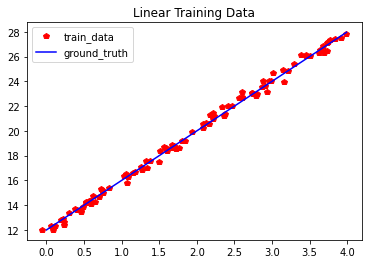

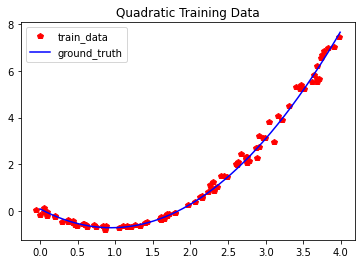

In [45]:
# Visualizing Data 

x = np.arange(0,rng,0.01)
y_lin, y_quad = lin(x), quad(x)

plt.plot(lin_data['train_x'], lin_data['train_y'], 'rp')
plt.plot(x, y_lin,'b')
plt.legend(['train_data', 'ground_truth'])
plt.title('Linear Training Data')
plt.show()

plt.plot(quad_data['train_x'], quad_data['train_y'], 'rp')
plt.plot(x, y_quad,'b')
plt.legend(['train_data', 'ground_truth'])
plt.title('Quadratic Training Data')
plt.show()

In [46]:
# Forward Propagation

def cost(z,y,m):
  delta = abs(z-y)
  loss = (1/np.size(z))*np.sum(delta**m)
  dZ = m*(delta**(m-1))*np.sign(z-y)
  return loss,dZ

def lin_for_prop(w,b,x,y,m):
  z = w*x + b
  return cost(z,y,m)

def quad_for_prop(a,b,c,x,y,m):
  z = a*(x**2) + b*x + c
  return cost(z,y,m)

In [47]:
# Backward Propagation
def lin_back_prop(w,b,x,dZ):
  dw = (1/np.size(x))*np.sum(dZ*x)
  db = (1/np.size(x))*np.sum(dZ)
  return dw,db

def quad_back_prop(a,b,c,x,dZ):
  da = (1/np.size(x))*np.sum(dZ*(x**2))
  db = (1/np.size(x))*np.sum(dZ*x)
  dc = (1/np.size(x))*np.sum(dZ)
  return da,db,dc

In [48]:
# Train Functions

def lin_train(data,w,b,m,initialize_weights=False,learning_rate=0.0001,epochs=300000):
  print(f"Training Linear Regression Model using COST = (y-z)**{m}")

  if initialize_weights:
    w,b = np.random.randn(),0

  train_loss, test_loss = [],[]
  min_loss = float('inf')

  x,y = data['train_x'], data['train_y']
  xtst, ytst = data['test_x'], data['test_y']

  for i in range(epochs):
    loss1, dZ = lin_for_prop(w,b,x,y,m)
    loss2, _ = lin_for_prop(w,b,xtst,ytst,m)

    if i%10000==0:
      print(f"Cost after {i+1} iterations : Training Loss =  {loss1}; Validation Loss = {loss2}")

    train_loss.append(loss1)
    test_loss.append(loss2)

    if loss2 < min_loss:
      min_loss = loss2
      W,B = w,b

    dw,db = lin_back_prop(w,b,x,dZ)
    w = w - learning_rate*dw
    b = b - learning_rate*db 

    if loss1 == float('inf'):
      w,b = np.random.randn(0),0

  print(f"Training Complete : min_loss_achieved = {min_loss}; W,B = {W,B}")

  return W,B,train_loss,test_loss


def quad_train(data,a,b,c,m,initialize_weights=False,learning_rate=0.0001,epochs=300000):
  print(f"Training Quadratic Regression Model using COST = (y-z)**{m}")

  if initialize_weights:
    a,b,c = np.random.randn(2),0

  train_loss, test_loss = [],[]
  min_loss = float('inf') 

  x, y = data['train_x'], data['train_y']
  xtst, ytst = data['test_x'], data['test_y']

  for i in range(epochs):
    loss1, dZ = quad_for_prop(a,b,c,x,y,m)
    loss2, _ = quad_for_prop(a,b,c,xtst,ytst,m)

    if i%10000==0:
      print(f"Cost after {i+1} iterations : Training Loss =  {loss1}; Validation Loss = {loss2}")
    
    train_loss.append(loss1)
    test_loss.append(loss2)

    if loss2 < min_loss:
      min_loss = loss2
      A,B,C = a,b,c

    da,db,dc = quad_back_prop(a,b,c,x,dZ)
    a = a - learning_rate*da
    b = b - learning_rate*db
    c = c - learning_rate*dc 

    if loss1 == float('inf'):
      a,b,c = np.random.randn(3)
    
  print(f"Training Complete : min_loss_achieved = {min_loss}; A,B,C = {A,B,C}")

  return A,B,C,train_loss,test_loss

In [49]:
# Initializing weights
L1,Q2,Q1 = np.random.randn(3)
L0,Q0 = 0,0

lin_results, quad_results = [],[]

In [50]:
# Model-1 Training
lin_results.append(lin_train(lin_data,L1,L0,1))

Training Linear Regression Model using COST = (y-z)**1
Cost after 1 iterations : Training Loss =  20.97845773566197; Validation Loss = 20.710049285396714
Cost after 10001 iterations : Training Loss =  16.23255643507964; Validation Loss = 16.07014125684174
Cost after 20001 iterations : Training Loss =  11.486655134498998; Validation Loss = 11.430233228288403
Cost after 30001 iterations : Training Loss =  6.740753833910865; Validation Loss = 6.790325199727731
Cost after 40001 iterations : Training Loss =  3.601464119343953; Validation Loss = 3.778164622243384
Cost after 50001 iterations : Training Loss =  3.289955370866638; Validation Loss = 3.574517148262208
Cost after 60001 iterations : Training Loss =  3.1242573075107103; Validation Loss = 3.4151821549159416
Cost after 70001 iterations : Training Loss =  2.964106068865876; Validation Loss = 3.24159265357934
Cost after 80001 iterations : Training Loss =  2.803954797028107; Validation Loss = 3.0680007498397157
Cost after 90001 iteration

In [51]:
# Model-2 Training
lin_results.append(lin_train(lin_data,L1,L0,3))

Training Linear Regression Model using COST = (y-z)**3
Cost after 1 iterations : Training Loss =  11095.925809180635; Validation Loss = 11210.467629640947
Cost after 10001 iterations : Training Loss =  0.935337233803668; Validation Loss = 1.3073409916193615
Cost after 20001 iterations : Training Loss =  0.2058421635736813; Validation Loss = 0.27480780507202607
Cost after 30001 iterations : Training Loss =  0.09730852895667098; Validation Loss = 0.11855372618862516
Cost after 40001 iterations : Training Loss =  0.06469813583626284; Validation Loss = 0.07144643858559697
Cost after 50001 iterations : Training Loss =  0.05133261345005845; Validation Loss = 0.05235282620933327
Cost after 60001 iterations : Training Loss =  0.04497802594398802; Validation Loss = 0.04340558608420644
Cost after 70001 iterations : Training Loss =  0.04171707465540111; Validation Loss = 0.038906252551626753
Cost after 80001 iterations : Training Loss =  0.03996727157704402; Validation Loss = 0.03655121412637336


In [52]:
# Model-3 Training
quad_results.append(quad_train(quad_data,Q2,Q1,Q0,4))

Training Quadratic Regression Model using COST = (y-z)**4
Cost after 1 iterations : Training Loss =  2319.5883800259007; Validation Loss = 2563.3525769647254
Cost after 10001 iterations : Training Loss =  0.05894937454201411; Validation Loss = 0.06387900371284767
Cost after 20001 iterations : Training Loss =  0.03827473235937226; Validation Loss = 0.04760017558854274
Cost after 30001 iterations : Training Loss =  0.03138408875787906; Validation Loss = 0.04017060177056545
Cost after 40001 iterations : Training Loss =  0.02693517369084481; Validation Loss = 0.034313611044688046
Cost after 50001 iterations : Training Loss =  0.02363035630051441; Validation Loss = 0.02961574572744828
Cost after 60001 iterations : Training Loss =  0.021068928629720422; Validation Loss = 0.025856820994484404
Cost after 70001 iterations : Training Loss =  0.019036368195580324; Validation Loss = 0.022829724175620215
Cost after 80001 iterations : Training Loss =  0.017394553771040846; Validation Loss = 0.020366

In [53]:
# Model-4 Training
quad_results.append(quad_train(quad_data,Q2,Q1,Q0,7))

Training Quadratic Regression Model using COST = (y-z)**7
Cost after 1 iterations : Training Loss =  1888574.9619881115; Validation Loss = 2103684.41335991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


Cost after 10001 iterations : Training Loss =  0.013811447385100411; Validation Loss = 0.013278809020107673
Cost after 20001 iterations : Training Loss =  0.006977234354186082; Validation Loss = 0.006494662200988879
Cost after 30001 iterations : Training Loss =  0.004929749853059002; Validation Loss = 0.004372180933599061
Cost after 40001 iterations : Training Loss =  0.003966940099074631; Validation Loss = 0.003352021921534727
Cost after 50001 iterations : Training Loss =  0.0034120154914847266; Validation Loss = 0.0027580012132327313
Cost after 60001 iterations : Training Loss =  0.003052363787881114; Validation Loss = 0.0023720044909567844
Cost after 70001 iterations : Training Loss =  0.0028006911442396373; Validation Loss = 0.002102643186468637
Cost after 80001 iterations : Training Loss =  0.0026147521878318787; Validation Loss = 0.0019049655434426902
Cost after 90001 iterations : Training Loss =  0.0024716729890694837; Validation Loss = 0.0017543070679553164
Cost after 100001 it

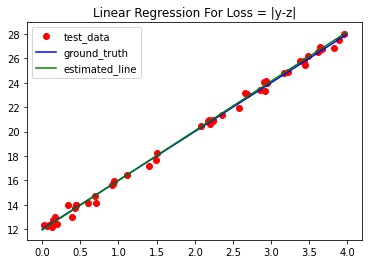

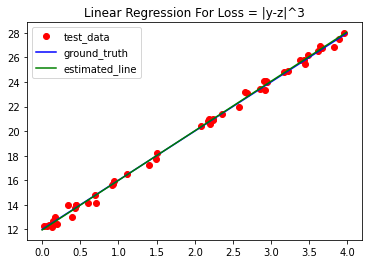

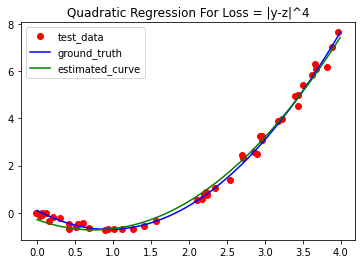

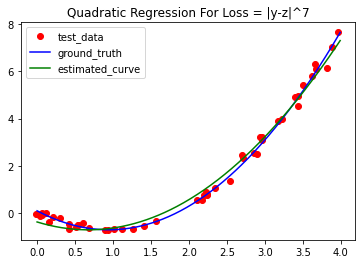

In [54]:
# Visualizing Individual Results :

W,B,_,_ = lin_results[0]
y = lambda x : W*x + B
plt.plot(lin_data['test_x'], lin_data['test_y'], 'ro')
plt.plot(x, y_lin, 'b')
plt.plot(x, y(x), 'g')
plt.legend(['test_data', 'ground_truth', 'estimated_line'])
plt.title('Linear Regression For Loss = |y-z|')
plt.show()

W,B,_,_ = lin_results[1]
y = lambda x : W*x + B
plt.plot(lin_data['test_x'], lin_data['test_y'], 'ro')
plt.plot(x, y_lin, 'b')
plt.plot(x, y(x), 'g')
plt.legend(['test_data', 'ground_truth', 'estimated_line'])
plt.title('Linear Regression For Loss = |y-z|^3')
plt.show()

A,B,C,_,_ = quad_results[0]
y = lambda x : A*(x**2) + B*x + C
plt.plot(quad_data['test_x'], quad_data['test_y'], 'ro')
plt.plot(x, y_quad, 'b')
plt.plot(x, y(x), 'g')
plt.legend(['test_data', 'ground_truth', 'estimated_curve'])
plt.title('Quadratic Regression For Loss = |y-z|^4')
plt.show()

A,B,C,_,_ = quad_results[1]
y = lambda x : A*(x**2) + B*x + C
plt.plot(quad_data['test_x'], quad_data['test_y'], 'ro')
plt.plot(x, y_quad, 'b')
plt.plot(x, y(x), 'g')
plt.legend(['test_data', 'ground_truth', 'estimated_curve'])
plt.title('Quadratic Regression For Loss = |y-z|^7')
plt.show()




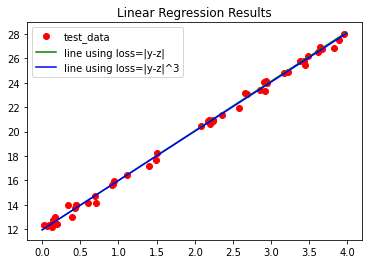

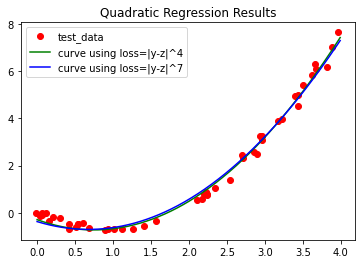

In [55]:
# Comparing the Estimated Curves

W,B,_,_ = lin_results[0]
W1,B1,_,_ = lin_results[1]
y = lambda x : W*x + B
g = lambda x : W1*x + B1
plt.plot(lin_data['test_x'], lin_data['test_y'], 'ro')
plt.plot(x, y(x), 'g')
plt.plot(x, g(x), 'b')
plt.legend(['test_data', 'line using loss=|y-z|', 'line using loss=|y-z|^3'])
plt.title('Linear Regression Results')
plt.show()

A,B,C,_,_ = quad_results[0]
A1,B1,C1,_,_ = quad_results[1]
y = lambda x : A*(x**2) + B*x + C
g = lambda x : A1*(x**2) + B1*x + C1
plt.plot(quad_data['test_x'], quad_data['test_y'], 'ro')
plt.plot(x, y(x), 'g')
plt.plot(x, g(x), 'b')
plt.legend(['test_data', 'curve using loss=|y-z|^4', 'curve using loss=|y-z|^7'])
plt.title('Quadratic Regression Results')
plt.show()

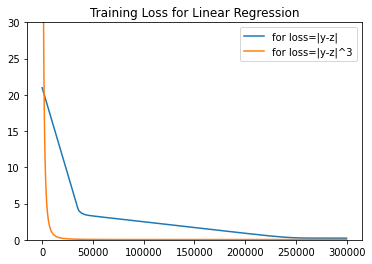

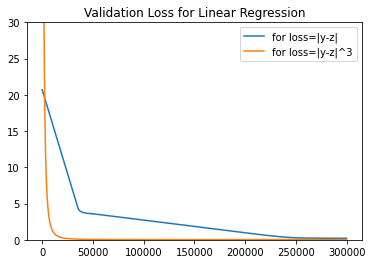

In [56]:
# Comparing Linear Regression Loss Curves 

_,_,train_loss,test_loss = lin_results[0]
_,_,train_loss1,test_loss1 = lin_results[1] 

plt.plot(train_loss)
plt.plot(train_loss1)
plt.legend(['for loss=|y-z|','for loss=|y-z|^3'])
plt.title('Training Loss for Linear Regression')
plt.ylim((0,30))
plt.show()

plt.plot(test_loss)
plt.plot(test_loss1)
plt.legend(['for loss=|y-z|','for loss=|y-z|^3'])
plt.title('Validation Loss for Linear Regression')
plt.ylim((0,30))
plt.show()

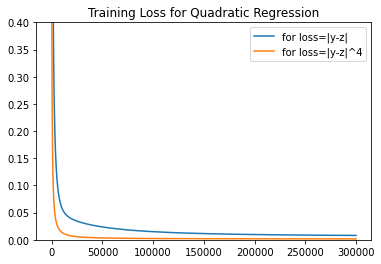

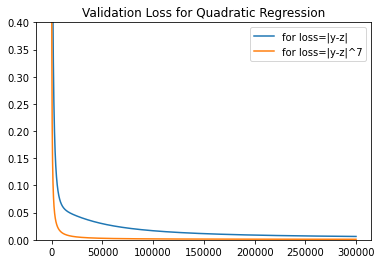

In [63]:
# Comparing Quadratic Regression Loss Curves 

_,_,_,train_loss,test_loss = quad_results[0]
_,_,_,train_loss1,test_loss1 = quad_results[1] 

plt.plot(train_loss)
plt.plot(train_loss1)
plt.legend(['for loss=|y-z|','for loss=|y-z|^4'])
plt.title('Training Loss for Quadratic Regression')
plt.ylim((0,0.4))
plt.show()

plt.plot(test_loss)
plt.plot(test_loss1)
plt.legend(['for loss=|y-z|','for loss=|y-z|^7'])
plt.title('Validation Loss for Quadratic Regression')
plt.ylim((0,0.4))
plt.show()